<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_ImageClassification_FinetuningVGG19_DataSpartan_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiLabel Image Classification 

In this notebook we generate a model that extends (transfer learning) a `VGG-19` model with a weights of `ImageNet` to try to classify images of figure (from a **non public dataset**).

Adapted from [link](https://analyticsindiamag.com/transfer-learning-for-multi-class-image-classification-using-deep-convolutional-neural-network/)

----
We will implement the multiclass image classification using the VGG-19 Deep Convolutional Network used as a Transfer Learning framework where the VGGNet comes pre-trained on the ImageNet dataset.

**What is Transfer Learning?**

Transfer learning stores the knowledge gained while solving one problem and applies it to a different but related problem. For example, the knowledge gained while learning to recognize cats could apply when trying to recognize cheetahs. In deep learning, transfer learning is a technique whereby a neural network model is first trained on a problem similar to the problem that is being solved. Transfer learning has the advantage of decreasing the training time for a learning model and can result in lower generalization error.

**VGGNet – The Deep Convolutional Network**

VGGNet is Deep Convolutional Neural Network that was proposed by Karen Simonyan and Andrew Zisserman of the University of Oxford in their research work ‘Very Deep Convolutional Neural Networks for Large-Scale Image Recognition’. The name of this model was inspired by the name of their research group ‘Visual Geometry Group (VGG)’. As this convolutional neural network has 19 layers in its architecture, it was named VGG-19. This model was proposed to reduce the number of parameters in a convolutional neural network with improved training time. Below is the block diagram of VGG-19 that illustrates its architecture.

![VGGNet](https://mk0analyticsindf35n9.kinstacdn.com/wp-content/uploads/2020/05/VGG19.png)


In [3]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
import cv2
import shutil
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

## Dataset

### Download data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
dataset_folderpath = "/content/input"

In [9]:
if os.path.isdir(dataset_folderpath):
  !rm -R {dataset_folderpath}

In [10]:
from pathlib import Path
def mkdir(sfolderpath):
  folderpath = Path(sfolderpath)
  folderpath.mkdir(parents=True, exist_ok=True)

mkdir(dataset_folderpath)

In [11]:
!tar -xvf /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/DSFigureDataset.tar.gz -C {dataset_folderpath}

clear_output()

!ls {dataset_folderpath}

raw  setup.py


### Split `train`, `val` and `test` dataset

The `zip` contains a script to generate the ml dataset

In [12]:
% cd {dataset_folderpath}
!python setup.py

% cd /content/

/content/input
Number of classes : 20
['VennDiagram', 'AreaGraph', 'BubbleChart', 'RadarPlot', 'PersonPhoto', 'TreeDiagram', 'LineGraph', 'NetworkDiagram', 'Map', 'ScatterGraph', 'HorizontalBarGraph', 'GeneralPhoto', 'ParetoChart', 'GeneralFigure', 'Signatures', 'FlowChart', 'BoxPlot', 'Table', 'PieChart', 'VerticalBarGraph']
VennDiagram: 
   > ntrain : 213
   > nval : 88
   > ntest : 4

AreaGraph: 
   > ntrain : 157
   > nval : 65
   > ntest : 3

BubbleChart: 
   > ntrain : 170
   > nval : 70
   > ntest : 3

RadarPlot: 
   > ntrain : 160
   > nval : 66
   > ntest : 3

PersonPhoto: 
   > ntrain : 160
   > nval : 66
   > ntest : 3

TreeDiagram: 
   > ntrain : 164
   > nval : 68
   > ntest : 3

LineGraph: 
   > ntrain : 156
   > nval : 65
   > ntest : 3

NetworkDiagram: 
   > ntrain : 183
   > nval : 76
   > ntest : 3

Map: 
   > ntrain : 271
   > nval : 113
   > ntest : 4

ScatterGraph: 
   > ntrain : 146
   > nval : 60
   > ntest : 3

HorizontalBarGraph: 
   > ntrain : 149
   > nval : 

In [13]:
input_folder = "/content/input/dataset"

!ls {input_folder} 

test  test_raw	train  val


In [14]:
trn_folder = os.path.join(input_folder,"train")
val_folder = os.path.join(input_folder,"val")
test_folder = os.path.join(input_folder,"test")
testraw_folder = os.path.join(input_folder,"test_raw")

In [15]:
classes = [name for name in os.listdir(trn_folder) 
      if os.path.isdir(os.path.join(trn_folder,name))]
print(f"Number of classes : {len(classes)}")
print(classes)

Number of classes : 20
['VennDiagram', 'AreaGraph', 'BubbleChart', 'RadarPlot', 'PersonPhoto', 'TreeDiagram', 'LineGraph', 'NetworkDiagram', 'Map', 'ScatterGraph', 'HorizontalBarGraph', 'GeneralPhoto', 'ParetoChart', 'GeneralFigure', 'Signatures', 'FlowChart', 'BoxPlot', 'Table', 'PieChart', 'VerticalBarGraph']


In [17]:
# Output of script
total_test=62

### Data preparation

Train and Val files are distributed in each folder with subfolders by class:

```
 folder\
    cls1\
        image.png
        image2.jpeg
        image3.png
        ...
    cls2\
        imageA.jpeg
        imageB.jpg
        imageC.png
        ...
    ...
```

We resize all the images to the same size.

In [18]:
IMG_HEIGHT = 550
IMG_WIDTH = 550
batch_size = 4

In [19]:
# With transform
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [20]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=trn_folder,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 3520 images belonging to 20 classes.


In [42]:
total_train=len(train_data_gen.filenames)
total_train

3520

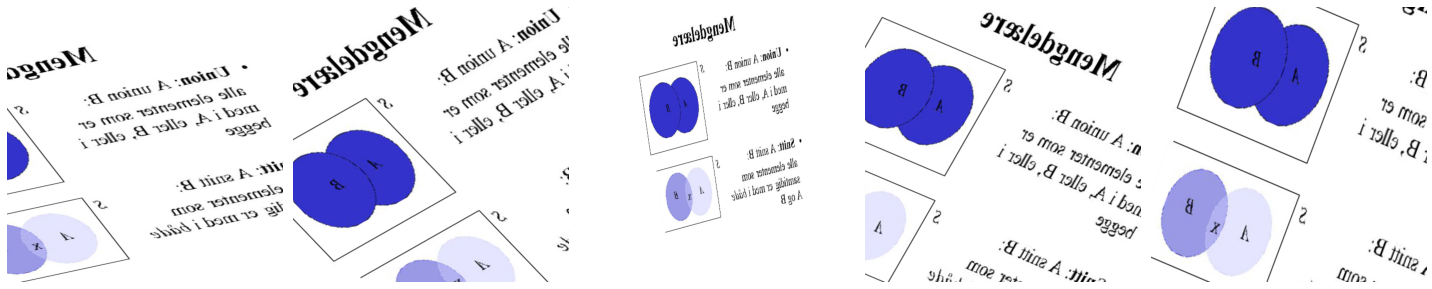

In [22]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [23]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [24]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_folder,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

Found 1458 images belonging to 20 classes.


In [41]:
total_val=len(val_data_gen.filenames)
total_val

1458

The `test` dataset is a list of images in a folder without associated label.

In [29]:
test_images = []
shape = (IMG_HEIGHT,IMG_WIDTH)

for filename in os.listdir(testraw_folder):
  img = cv2.imread(os.path.join(testraw_folder,filename))

  # Resize all images to a specific shape
  img = cv2.resize(img,shape)

  test_images.append(img)
        
# Converting test_images to array
test_images = np.array(test_images)

## Model

In [30]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)

In [31]:
#Defining the VGG Convolutional Neural Net
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (IMG_HEIGHT,IMG_WIDTH,3), classes = len(classes))

80142336/80134624 [==============================] - 4s 0us/step


In [32]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [33]:
#Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 17, 17, 512)       20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 147968)            0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [34]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(len(classes),activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 17, 17, 512)       20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 147968)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              151520256 
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [35]:
#Initializing the hyperparameters
batch_size=batch_size
epochs=10
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Training the model
model.fit_generator(
    train_data_gen,
    epochs=epochs,
    steps_per_epoch=total_train // batch_size,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[lrr], verbose = 1)

Epoch 1/10
880/880 [==============================] - 550s 625ms/step - loss: 2.9729 - accuracy: 0.0770 - val_loss: 3.0222 - val_accuracy: 0.0776
Epoch 2/10
880/880 [==============================] - 550s 626ms/step - loss: 2.9728 - accuracy: 0.0770 - val_loss: 3.0542 - val_accuracy: 0.0777
Epoch 3/10
880/880 [==============================] - 549s 624ms/step - loss: 2.9723 - accuracy: 0.0764 - val_loss: 3.0543 - val_accuracy: 0.0777
Epoch 4/10
880/880 [==============================] - 549s 624ms/step - loss: 2.9726 - accuracy: 0.0770 - val_loss: 2.9349 - val_accuracy: 0.0770
Epoch 5/10
880/880 [==============================] - 549s 624ms/step - loss: 2.9726 - accuracy: 0.0770 - val_loss: 2.8520 - val_accuracy: 0.0784
Epoch 6/10
880/880 [==============================] - 549s 623ms/step - loss: 2.9723 - accuracy: 0.0770 - val_loss: 3.0534 - val_accuracy: 0.0770
Epoch 7/10
161/880 [====>.........................] - ETA: 6:25 - loss: 2.9725 - accuracy: 0.0606

In [ ]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [ ]:
test_data_gen = image_gen_val.flow_from_directory(batch_size=1,
                                                 directory=test_folder,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

number_of_examples = len(test_data_gen.filenames)
test_labels = []
for i in range(0,number_of_examples):
    test_labels.extend(np.array(test_data_gen[i][1]))

In [ ]:
#Making prediction
y_pred=model.predict(test_data_gen, steps=number_of_examples)
y_pred=np.argmax(y_pred,axis=1)
y_true=np.argmax(test_labels,axis=1)

Visualize the classification performance

In [ ]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

First, we will see the exact number of correct and incorrect classification using the non-normalized confusion matrix and then we will see the same in percentage using the normalized confusion matrix. 

In [ ]:
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

classes.sort()

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = classes, title='Confusion matrix, without normalization')

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = classes, normalize = True, title = 'Normalized confusion matrix')